In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (17.0, 77.0)

import pylab
from tsne import bh_sne
from matplotlib import pyplot as plt
import pandas
import scipy
import numpy as np
import sklearn.manifold
import os
import gc
from time import gmtime, strftime
import seaborn as sns
from os import listdir
from os.path import isfile, join
import math
from scipy.stats.stats import pearsonr
import random as rand
import pyproj
import functools

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:


def load_data(path):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        # if label != 'hcad':
        data_dict[label] = df[label].astype(float)
        # df[label][df[label] > 1] = 1.0

    # df['hcad'] = df['hcad'].astype(float)
    result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    return result.sort(['hcad']).fillna(0)
def display_heightmap(mat):
    plt.imshow((mat), interpolation='nearest')
    plt.show()


In [3]:
meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")

loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode


In [4]:


wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

def feet_to_lon_lat(x,y):
    x = [x*.3048] # convert to meters
    y = [y*.3048]
    return pyproj.transform(UTM26N, wgs84, x, y)



In [5]:
from os import listdir
from os.path import isfile, join

file_attributes = {}

mypath = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files"
for filename in [f for f in listdir(mypath) if isfile(join(mypath, f))]: 
    attributes = {}
    with open(mypath + "/" + filename) as FileObj:
        for index, line in enumerate(FileObj):
            if(index < 6):
#                 print line
                attributes[line.split(" ")[0]] = int(line.split(" ")[-1][:-2])
            else:
                break # don't load the other lines into memory becuase that's a waste of time.

#     pickle_path = "/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/" + filename + ".npy"
#     f = file(pickle_path,"wb")
#     mat = np.loadtxt(mypath + "/" + filename, dtype='float16', comments='#', delimiter=" ", converters=None, skiprows=6, usecols=range(0,attributes['ncols']), unpack=False, ndmin=0)
#     np.save(f, mat)
#     f.close()
    attributes['width'] = attributes['ncols'] * attributes['cellsize']
    attributes['height'] = attributes['nrows'] * attributes['cellsize']
    file_attributes[filename] = attributes
print "loaded all file header attributes into dict"

loaded all file header attributes into dict


In [6]:
from collections import deque

def memoize(obj, maxlen = 20):
    """A decorator to cache advice objects using the advice key"""
    cache = obj.cache = {}
    deck = obj.deck = deque([], maxlen = maxlen)

    @functools.wraps(obj)
    def memoizer(*args, **kwargs):
        key = args[0]
        if key not in cache:
            if len(deck) == deck.maxlen:
              del cache[deck.popleft()[0]]
            temp = obj(*args, **kwargs)
            cache[key] = temp
            deck.append((key, temp))
        return cache[key]

    return memoizer

@memoize
def load_mat_from_file(key):
    f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/"+key+".npy","rb")
    return np.load(f)

def get_file_containing(housex, housey):
#         print "house coords:", housex, housey
        for key in file_attributes:
            block = file_attributes[key]
    #         print block['xllcorner'], block['yllcorner']
            if block['xllcorner'] < housex < block['xllcorner'] + block['width']:
                if block['yllcorner'] < housey < block['yllcorner'] + block['height']:
                    return key


#housex and housey in meters
def get_heightmap_around(housex, housey, window_width_feet = 200, window_width_pixels = 28):
    housex /= .3048 #convert to feet
    housey /= .3048  
    x=housex
    y=housey

    key = get_file_containing(x,y)
    block = file_attributes[key]
#     print "found map:", key, block['xllcorner'], block['yllcorner'], block['width'], block['height']

    mat = load_mat_from_file(key)
    imagex = (int(x)-block['xllcorner'])/5
    imagey = (int(y)-block['yllcorner'])/5
#                 print imagex, imagey

    x1 = np.max([0,              imagex - window_width_pixels/2])
    x2 = np.min([block['ncols'], imagex+window_width_pixels/2])

    y1 = np.max([0,              imagey - window_width_pixels/2])
    y2 = np.min([block['nrows'], imagey+window_width_pixels/2])

#     display_heightmap(mat)
#     mat[mat< -9000] = 0
#     mat -= np.mean(mat.flatten(), dtype=np.float64)
#     mat /= mat.std(dtype=np.float64)
#     print "min max", np.min(mat), np.max(mat)

#     display_heightmap((mat[block['nrows']-y2:block['nrows']-y1,
#                           x1:x2]))
    result = mat[block['nrows']-y2:block['nrows']-y1, x1:x2]
    return result


def window_violated_chunk_borders(housex, housey):
    corners = [(housex-window_width_feet/2, housey-window_width_feet/2),
              (housex-window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey+window_width_feet/2),
              (housex+window_width_feet/2, housey-window_width_feet/2)]
    files = map(lambda x: get_file_containing(x[0], x[1]), corners)
    return len(set(files)) > 1

house lat lon [29.920000076293945] [-95.084800720214844]
[977962.9843141946] [4237588.749906508]


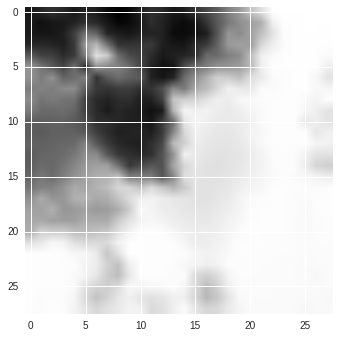

In [7]:

lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
plt.imshow(get_heightmap_around(housex, housey))
plt.show()

In [19]:
image_width = 28

wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum

# lon = [meta['lon'][250000]] #these are good becuase of clear local features
# lat = [meta['lat'][250000]]


lon = [meta['lon'][12000]]
lat = [meta['lat'][12000]]

print "house lat lon", lat, lon
xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
print xx, yy
housex=xx[0]
housey=yy[0]
get_heightmap_around(housex,housey)

n=20000
metamat = np.zeros([n,1,image_width,image_width])
metaY = np.zeros([n])
for i in range(n):
    
    index = rand.randint(0, len(meta)-1)
    lon = [meta['lon'][index]]
    lat = [meta['lat'][index]]

    xx, yy = pyproj.transform(wgs84, UTM26N, lon, lat)
    housex=xx[0]
    housey=yy[0]
    
    
    new_element = np.array([get_heightmap_around(housex, housey, window_width_pixels=image_width)])
    if new_element.shape == (1,image_width,image_width):
        metamat[i] = new_element
        metaY[i] = y_data['y200_mean'][index]
    else:
        i -= 1
    if i%1000 == 0:
        print i
    
print metamat.shape
print metamat
print metaY
f = file("20000Random100x100Slices.np","wb")
np.save(f, metamat)
f.close()

f = file("20000RandomY.np","wb")
np.save(f, metaY)
f.close()


house lat lon [29.920000076293945] [-95.084800720214844]
[977962.9843141946] [4237588.749906508]
0
1000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
(20000, 1, 28, 28)
[[[[  43.03125   43.03125   43.0625  ...,   43.40625   43.53125   43.53125]
   [  43.125     43.15625   43.1875  ...,   43.34375   43.375     43.34375]
   [  43.125     43.125     43.15625 ...,   43.125     43.09375   42.96875]
   ..., 
   [  47.21875   45.96875   42.75    ...,   42.78125   43.0625    43.     ]
   [  44.8125    46.65625   43.53125 ...,   42.875     43.0625    43.03125]
   [  45.5       43.40625   42.71875 ...,   42.84375   42.96875   43.09375]]]


 [[[  55.875     65.4375    75.8125  ...,   32.34375   35.0625    35.15625]
   [  53.1875    67.75      77.0625  ...,   32.46875   32.40625   32.53125]
   [  63.84375   68.5625    76.25    ...,   32.53125   32.53125   32.4375 ]
   ..., 
   [  45.34375   44.875     44.65625 ...,   56.65625   47.78125   43.6875 ]


In [ ]:
plt.imshow(mat[:,:])
plt.show()

You can compare the image displayed here with google maps to convince yourself that this is the correct map in the right orientation

In [ ]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q116.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q116.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(2957465, 13901720)
display_heightmap(matloaded)

In [ ]:
f = file("/home/isaac/Desktop/devika/ARCGIS/ArcGis/pickle_files/rastert_dsm_q247.txt.npy","rb")
matloaded = np.load(f)
with open("/home/isaac/Desktop/devika/ARCGIS/ArcGis/ascii_files/rastert_dsm_q247.txt") as myfile:
    head = "".join([next(myfile) for x in xrange(6)])
print head

print feet_to_lon_lat(3059015+4105*5, 13813630+4665*5)
display_heightmap(matloaded[:500,4105-500:].clip(-100,100))